Import Libraries

In [3]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Load Ecuador Earthquake Data

In [4]:
def load_data(train_path, dev_path, test_path):
    train_df = pd.read_csv(train_path, sep="\t")
    dev_df = pd.read_csv(dev_path, sep="\t")
    test_df = pd.read_csv(test_path, sep="\t")

    # Combine train data and dev data for better training
    train_df = pd.concat([train_df, dev_df], ignore_index=True)
    return train_df, test_df

train_path = "/content/ecuador_earthquake_2016_train.tsv"
dev_path = "/content/ecuador_earthquake_2016_dev.tsv"
test_path = "/content/ecuador_earthquake_2016_test.tsv"

train_df, test_df = load_data(train_path, dev_path, test_path)

In [5]:
train_df

,tweet_id,tweet_text,class_label
0,721872405916856321,Powerful Ecuador quake kills at least 235: POR...,injured_or_dead_people
1,721920840800018432,Im at awe and saddened with the #EcuadorEarthq...,rescue_volunteering_or_donation_effort
2,721851949344256000,RT @RachelAndJun: Our hearts are with everyone...,sympathy_and_support
3,721720535030304769,RT @noticias2000: Ecuador quake death toll has...,injured_or_dead_people
4,721719197429035008,RT @pzf: BREAKING PHOTOS: Major damage reporte...,infrastructure_and_utility_damage
...,...,...,...
1248,721829230070394881,RT @Anna_cast3: All help is welcome Ecuador ne...,sympathy_and_support
1249,721750866433306625,"RT @gabydearest: Dear friends, please consider...",rescue_volunteering_or_donation_effort
1250,722024644685864961,Ecuadors President Correa said the death toll ...,injured_or_dead_people
1251,721804839718678532,RT @Magdanifica1: If Mexico would send bottled...,not_humanitarian


In [6]:
test_df

,tweet_id,tweet_text,class_label
0,721630546711986178,RT @RaptorCulture: #Ecuador is in confusion af...,other_relevant_information
1,721797683745202177,RT @ShakingEarth: Massive #Earthquake #Ecuador...,injured_or_dead_people
2,721702262435930112,RT @PSYCHICTWINS: Huge Ecuador earthquake of 7...,sympathy_and_support
3,722209089128833024,#rt Ecuador quake death toll hits 413: At leas...,injured_or_dead_people
4,721959342895972352,@BTS_twt is sad ὢD but..It would be really imp...,injured_or_dead_people
...,...,...,...
305,722133660523171841,BBC News - Ecuador earthquake: Deaths rise to 272,injured_or_dead_people
306,721746848357199872,RT @edmac78: Sad to see images from yesterdays...,not_humanitarian
307,721858622582583296,"RT @ABC: Sec. Kerry offers condolences, assist...",sympathy_and_support
308,722093828958593024,How you can help survivors of the massive eart...,rescue_volunteering_or_donation_effort


ALL DATA

In [7]:
tweet_data = pd.concat([train_df, test_df], ignore_index=True)

In [8]:
tweet_data['class_label'].value_counts()

,count
class_label,
injured_or_dead_people,555
rescue_volunteering_or_donation_effort,394
sympathy_and_support,319
requests_or_urgent_needs,91
other_relevant_information,81
infrastructure_and_utility_damage,70
caution_and_advice,30
not_humanitarian,23


Data Preprocessing

In [9]:
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"\@\w+|\#", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\d+", "", text)
    return text.strip()

train_df["clean_text"] = train_df["tweet_text"].apply(clean_text)
test_df["clean_text"] = test_df["tweet_text"].apply(clean_text)

In [10]:
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X_train = vectorizer.fit_transform(train_df["clean_text"])
X_test = vectorizer.transform(test_df["clean_text"])

In [11]:
label_mapping = {label: idx for idx, label in enumerate(train_df["class_label"].unique())}
y_train = train_df["class_label"].map(label_mapping)
y_test = test_df["class_label"].map(label_mapping)

Define confusion matrix

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, model_name, class_labels):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

    plt.xlabel("Predicted Labels", fontsize=10)
    plt.ylabel("Actual Labels", fontsize=10)
    plt.title(f"Confusion Matrix - {model_name}", fontsize=10)

    plt.xticks(rotation=90)
    plt.yticks(rotation=0)

    plt.show()

class_labels = list(label_mapping.keys())


In [13]:
def evaluate_model(y_true, y_pred, model_name):
    precision = precision_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\n{model_name} Evaluation:")
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'F1 Score: {f1}')

    print("\n Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

Decision Tree

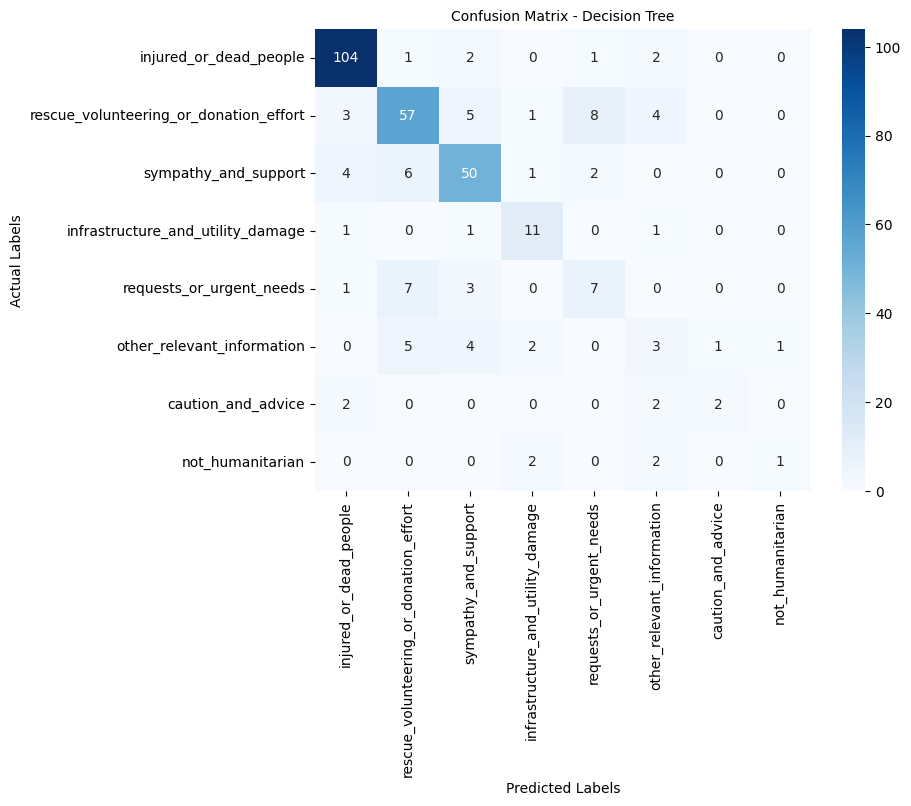


Decision Tree Evaluation:
Accuracy: 0.7580645161290323
Precision: 0.7497651428680223
F1 Score: 0.751221356759208

 Classification Report:
                                        precision    recall  f1-score   support

                injured_or_dead_people       0.90      0.95      0.92       110
rescue_volunteering_or_donation_effort       0.75      0.73      0.74        78
                  sympathy_and_support       0.77      0.79      0.78        63
     infrastructure_and_utility_damage       0.65      0.79      0.71        14
              requests_or_urgent_needs       0.39      0.39      0.39        18
            other_relevant_information       0.21      0.19      0.20        16
                    caution_and_advice       0.67      0.33      0.44         6
                      not_humanitarian       0.50      0.20      0.29         5

                              accuracy                           0.76       310
                             macro avg       0.61      0.55

In [14]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, f1_score, recall_score

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_preds = dt_model.predict(X_test)

plot_confusion_matrix(y_test, dt_preds, "Decision Tree", class_labels)
evaluate_model(y_test, dt_preds,"Decision Tree")


Random Forest

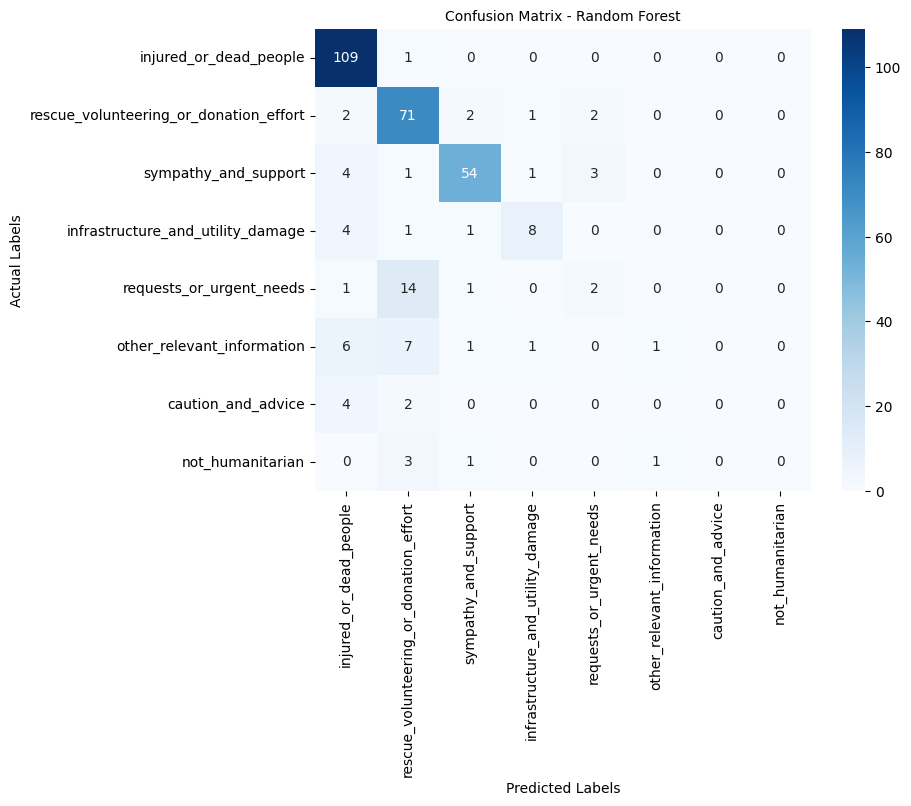


Random Forest Evaluation:
Accuracy: 0.7903225806451613
Precision: 0.7343078856627243
F1 Score: 0.7454072152138701

 Classification Report:
                                        precision    recall  f1-score   support

                injured_or_dead_people       0.84      0.99      0.91       110
rescue_volunteering_or_donation_effort       0.71      0.91      0.80        78
                  sympathy_and_support       0.90      0.86      0.88        63
     infrastructure_and_utility_damage       0.73      0.57      0.64        14
              requests_or_urgent_needs       0.29      0.11      0.16        18
            other_relevant_information       0.50      0.06      0.11        16
                    caution_and_advice       0.00      0.00      0.00         6
                      not_humanitarian       0.00      0.00      0.00         5

                              accuracy                           0.79       310
                             macro avg       0.50      0.4

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [15]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

plot_confusion_matrix(y_test, rf_preds, "Random Forest", class_labels)
evaluate_model(y_test, rf_preds,"Random Forest")

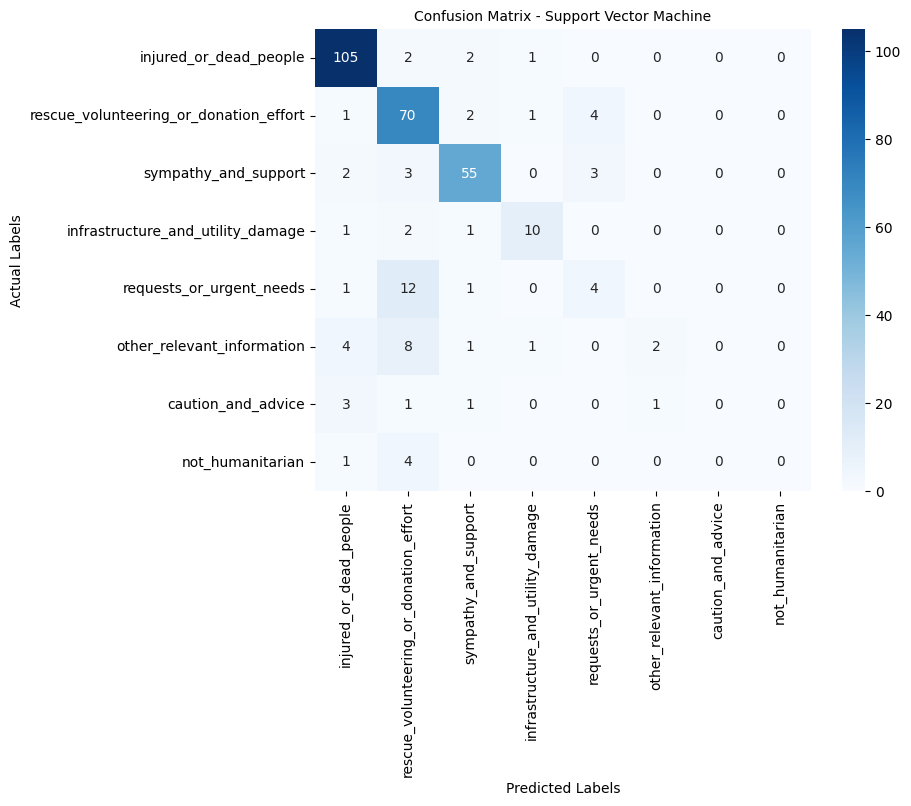


Support Vector Machine Evaluation:
Accuracy: 0.7935483870967742
Precision: 0.7561036118653589
F1 Score: 0.7602798864668778

 Classification Report:
                                        precision    recall  f1-score   support

                injured_or_dead_people       0.89      0.95      0.92       110
rescue_volunteering_or_donation_effort       0.69      0.90      0.78        78
                  sympathy_and_support       0.87      0.87      0.87        63
     infrastructure_and_utility_damage       0.77      0.71      0.74        14
              requests_or_urgent_needs       0.36      0.22      0.28        18
            other_relevant_information       0.67      0.12      0.21        16
                    caution_and_advice       0.00      0.00      0.00         6
                      not_humanitarian       0.00      0.00      0.00         5

                              accuracy                           0.79       310
                             macro avg       0.53

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [16]:
svm_model = SVC(kernel="linear", random_state=42)
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)

plot_confusion_matrix(y_test, svm_preds, "Support Vector Machine", class_labels)
evaluate_model(y_test, svm_preds,"Support Vector Machine")